### Imports ###

In [1]:
%reload_ext autoreload
%autoreload 2

%load_ext memory_profiler

import time as time_module
import psutil, os
import corner
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np

import jax
import jax.numpy as jnp
import blackjax
from blackjax.ns.utils import finalise, log_weights
print(jax.devices())

from data import get_data
from prior import prior_dists, logprior, sample_from_priors
from loglikelihood import loglikelihood
from model import jax_stream_model, sample_params_data

N_PARTICLES  = 10000 # Denis wants more particles 
N_STEPS      = 100 # Time resolution

[CpuDevice(id=0)]


### Define Parameters ###

In [2]:
logM, Rs, q, dirx, diry, dirz = 12., 20., 0.75, 1., 1., 0.5 
logm, rs = 8., 2.
x0, y0, z0 = 100., 0., 55.
vx0, vy0, vz0 = 25., 150., -50.
time = 3.
alpha = 1.0 

### Check Time and Memory ###

peak memory: 392.47 MiB, increment: 0.67 MiB
Time: 45.122 seconds
Memory before: 253.59 MB
Memory after:  214.06 MB
Memory used:   39.53 MB


Text(0.5, 1.0, '2023')

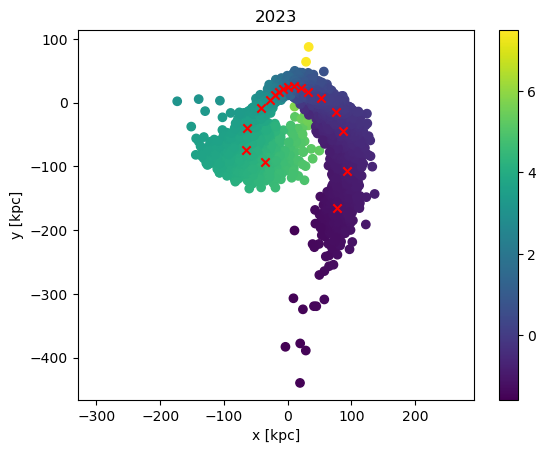

In [8]:
process = psutil.Process(os.getpid())

# Memory before
mem_before = process.memory_info().rss / 1e6

q_true = 0.75
seed = np.random.randint(0, 1000000)
logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha = sample_params_data(q_true, seed)

%memit
# Timed execution
start = time_module.time()

dict_data = get_data(q_true, seed, sigma=1, tail=0, min_count=101, n_theta_min=13, r_min=20, r_max=500, l_min=200, R2_max=0.8)

# theta_stream, x_stream, y_stream, vz_stream, r_meds, w_meds, x_meds, y_meds, vz_meds = jax_stream_model(
#     logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail=1, min_count=11
# )
end = time_module.time()

# Memory after
mem_after = process.memory_info().rss / 1e6

print(f"Time: {end - start:.3f} seconds")
print(f"Memory before: {mem_before:.2f} MB")
print(f"Memory after:  {mem_after:.2f} MB")
print(f"Memory used:   {mem_before - mem_after:.2f} MB")
    
plt.scatter(dict_data['x_stream'], dict_data['y_stream'], c=dict_data['theta_stream'])
plt.colorbar()
plt.scatter(dict_data['x_meds'], dict_data['y_meds'], c='r', marker='x')
plt.axis('equal')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.title(f"{seed}")

### Step by Step ###

In [39]:
from model import backward_integrate_orbit_leapfrog, forward_integrate_orbit_leapfrog, vector_NFW_Hessian, get_rj_vj_R, create_ic_particle_spray, leapfrog_stream_step, scalar_NFW_acceleration, scalar_Plummer_acceleration, jax_unwrap

In [15]:
xv_sat, _ = backward_integrate_orbit_leapfrog(x0, y0, z0, vx0, vy0, vz0,
                                            logM, Rs, q, dirx, diry, dirz,
                                            time)

xv_sat_forward, _ = forward_integrate_orbit_leapfrog(xv_sat[0, 0], xv_sat[0, 1], xv_sat[0, 2], xv_sat[0,3], xv_sat[0, 4], xv_sat[0, 5],
                                            logM, Rs, q, dirx, diry, dirz,
                                            time*alpha)

hessians = vector_NFW_Hessian(xv_sat_forward[:, 0], xv_sat_forward[:, 1], xv_sat_forward[:, 2],
                                logM, Rs, q, dirx, diry, dirz)

rj, vj, R = get_rj_vj_R(hessians, xv_sat_forward, 10 ** logm)

ic_particle_spray = create_ic_particle_spray(xv_sat_forward, rj, vj, R, tail=0)

In [ ]:
from astropy import units as auni

from astropy.constants import G
G = G.to(auni.kpc/auni.Msun*auni.km**2/auni.s**2).value # kpc (km/s)^2/Msun

KPC_TO_KM    = jnp.array( (1 * auni.kpc/auni.km).to(auni.km/auni.km).value)
GYR_TO_S     = jnp.array( (1 * auni.Gyr/auni.s).to(auni.s/auni.s).value)
# N_particles must be even and divisible by N_steps
N_PARTICLES  = 10100 # Denis wants more particles 
N_STEPS      = 100 # Time resolution
N_BINS       = 36

@jax.jit
def unwrap_step(theta_t, theta_unwrapped_prev):
    # bring the previous unwrapped back into [0, 2π)
    theta_prev_raw = jnp.mod(theta_unwrapped_prev, 2 * jnp.pi)
    # raw increment
    dtheta = theta_t - theta_prev_raw
    # wrap into (–π, π]
    dtheta = (dtheta + jnp.pi) % (2 * jnp.pi) - jnp.pi
    # accumulate
    return theta_unwrapped_prev + dtheta

@jax.jit
def forward_integrate_stream_leapfrog(index, x0, y0, z0, vx0, vy0, vz0,
                                        xv_sat, logM, Rs, q,
                                        dirx, diry, dirz, logm, rs, time):
    # State is a flat tuple of six scalars.
    xp, yp, zp, vxp, vyp, vzp = xv_sat[index]

    theta0 = jnp.arctan2(y0, x0)
    theta0 = jax.lax.cond(theta0 < 0, lambda x: x + 2 * jnp.pi, lambda x: x, theta0)

    state = (theta0, x0, y0, z0, vx0, vy0, vz0, xp, yp, zp, vxp, vyp, vzp)
    dt_sat = time / N_STEPS

    time_here = time - index * dt_sat
    dt_here = time_here / N_STEPS

    def step_fn(state, _):
        # Use only the first three elements of the satellite row.
        theta0, x0, y0, z0, vx0, vy0, vz0, xp, yp, zp, vxp, vyp, vzp = state

        initial_conditions = (x0, y0, z0, vx0, vy0, vz0, xp, yp, zp, vxp, vyp, vzp)
        final_conditions = leapfrog_stream_step(initial_conditions, dt_here,
                                            logM, Rs, q, dirx, diry, dirz, logm, rs)
        
        theta = jnp.arctan2(final_conditions[1], final_conditions[0])
        theta = jax.lax.cond(theta < 0, lambda x: x + 2 * jnp.pi, lambda x: x, theta)

        theta = unwrap_step(theta, theta0)

        new_state = (theta, *final_conditions)

        # The carry and output must have the same structure.
        return new_state, _ # jnp.stack(new_state)

    # Run integration over the satellite trajectory (using all but the last row).
    trajectory, _ = jax.lax.scan(step_fn, state, None, length=N_STEPS - 1)
    # 'trajectory' is a tuple of six arrays, each of shape (N_STEPS,).

    return jnp.array(trajectory)


@jax.jit
def generate_stream(ic_particle_spray, xv_sat, logM, Rs, q,
                    dirx, diry, dirz, logm, rs, time):
    # There are 16 parameters to forward_integrate_stream_leapfrog:
    # 6 come from ic_particle_spray (one per coordinate),
    # and the remaining 10 are shared (xv_sat, logM, Rs, q, dirx, diry, dirz, logm, rs, time).
    index = jnp.repeat(jnp.arange(0, N_STEPS, 1), N_PARTICLES// N_STEPS)  # Shape: (N_PARTICLES,)

    xv_stream = jax.vmap(
        forward_integrate_stream_leapfrog,
        in_axes=(0, 0, 0, 0, 0, 0, 0,  # map over each column of ic_particle_spray
                    None, None, None, None, None, None, None, None, None, None)  # shared arguments
    )(index,
        ic_particle_spray[:, 0],  # x0
        ic_particle_spray[:, 1],  # y0
        ic_particle_spray[:, 2],  # z0
        ic_particle_spray[:, 3],  # vx0
        ic_particle_spray[:, 4],  # vy0
        ic_particle_spray[:, 5],  # vz0
        xv_sat, # (xp, yp, zp, vxp, vyp, vzp)
        logM, Rs, q,
        dirx, diry, dirz, logm, rs, time)

    return xv_stream



In [34]:
xv_stream = generate_stream(ic_particle_spray, xv_sat_forward, logM, Rs, q,
                            dirx, diry, dirz, logm, rs, time)

In [35]:
xv_stream.shape

(10100, 13)

In [68]:
theta_sat = jnp.arctan2(xv_sat[:, 1], xv_sat[:, 0])
# Shift negative angles into [0, 2*pi].
theta_sat = jnp.where(theta_sat < 0, theta_sat + 2 * jnp.pi, theta_sat)
# Use our jax-unwrapped version to remove discontinuities.
theta_sat = jax_unwrap(theta_sat)
# Count how many complete 2pi rotations have been accumulated (integer division).
theta_count = jnp.floor_divide(theta_sat, 2 * jnp.pi)

final_theta_stream = (
    xv_stream[:, 0] #jnp.sum(theta_stream * diagonal_matrix, axis=1)
    - theta_sat[-1]
    + jnp.repeat(theta_count,  N_PARTICLES// N_STEPS) * 2 * jnp.pi
)

algin_reference = theta_sat[-1]- theta_count[-1]*(2*jnp.pi) # Make sure the angle of reference is at theta=0

final_theta_stream += (1 - jnp.sign(algin_reference - jnp.pi))/2 * algin_reference + \
                        (1 + jnp.sign(algin_reference - jnp.pi))/2 * (algin_reference - 2 * jnp.pi)

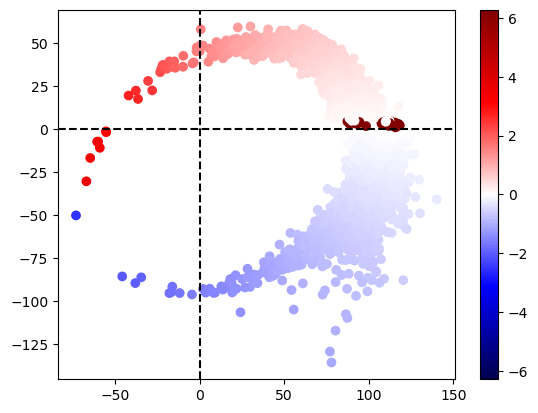

In [70]:
plt.scatter(xv_stream[:, 1], xv_stream[:, 2], c=final_theta_stream, cmap='seismic', vmin=-2*np.pi, vmax=2*np.pi)
plt.colorbar()
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')


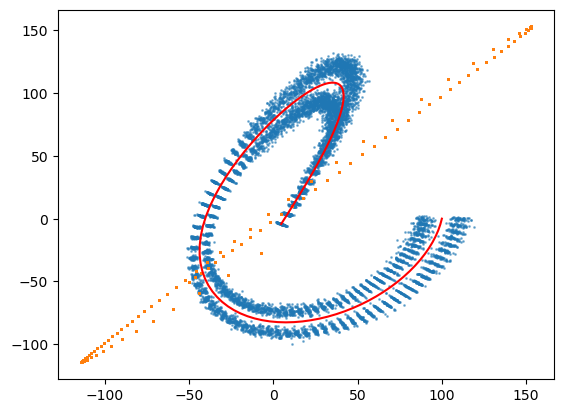

In [26]:
plt.scatter(ic_particle_spray[:, 0], ic_particle_spray[:, 1], s=1, alpha=0.5)
plt.plot(xv_sat_forward[:, 0], xv_sat_forward[:, 1], 'r')
plt.scatter(xv_stream[:,-1, 1], xv_stream[:, -1, 2], s=1, alpha=0.5)